## Módulo 10 - Classificação Árvore de Decisão



In [2]:
# Importações

# EDA
import pandas as pd
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Otimização de Hiperparêmetros
import optuna

# Salvar modelo
import joblib

# prototipar modelo - app de predição batch (por arquivo)
import gradio as gr

### Bloco 1 - AED



#### Setup, Carga dos Dados e EDA Inicial

Nesta aula, começamos a parte prática do projeto de classificação de empresas por segmento. Configuramos o ambiente virtual e importamos as bibliotecas necessárias, como pandas, plotly, matplotlib e scikit-learn. Em seguida, carregamos o dataset e realizamos a análise exploratória dos dados (EDA). Verificamos os valores únicos das variáveis categóricas, como atividade econômica, localização e segmento de clientes. Também observamos os valores possíveis da variável de inovação, que é uma variável ordinal. Não encontramos valores nulos no dataset.



In [3]:
df_segmento = pd.read_csv("../datasets/dataset_segmentos_clientes.csv")
df_segmento.head()

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,segmento_de_cliente
0,Comércio,713109.95,12,Rio de Janeiro,6,1,Bronze
1,Comércio,790714.38,9,São Paulo,15,0,Bronze
2,Comércio,1197239.33,17,São Paulo,4,9,Silver
3,Indústria,449185.78,15,São Paulo,6,0,Starter
4,Agronegócio,1006373.16,15,São Paulo,15,8,Silver


In [4]:
df_segmento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
 6   segmento_de_cliente     500 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.5+ KB


In [5]:
# valores possíveis - variáveis categóricas
print(f'atividade econômica: {df_segmento["atividade_economica"].unique()}')
print(f'localizacao: {df_segmento["localizacao"].unique()}')
print(f'segmento de cliente: {df_segmento["segmento_de_cliente"].unique()}')
print(f'inovação: {df_segmento["inovacao"].unique()}')

atividade econômica: ['Comércio' 'Indústria' 'Agronegócio' 'Serviços']
localizacao: ['Rio de Janeiro' 'São Paulo' 'Vitória' 'Belo Horizonte']
segmento de cliente: ['Bronze' 'Silver' 'Starter' 'Gold']
inovação: [1 0 9 8 4 6 3 7 5 2]


#### Análise Variáveis Qualitativas

Neste vídeo, continuamos nossa análise exploratória de dados (EDA) e focamos na distribuição das variáveis do nosso dataset. Começamos analisando a distribuição da variável target, que é o segmento de cliente que queremos prever. Observamos que a base está desbalanceada, com a maioria dos registros nos segmentos bronze e silver. Em seguida, utilizamos a biblioteca Plotly para criar gráficos de barras que mostram a distribuição do target de forma visual. Também analisamos a distribuição percentual do target e das variáveis localização, atividade econômica e inovação. Concluímos que há desbalanceamento na base em relação ao target, mas não nas outras variáveis categóricas.



In [6]:
# distribuição da variável "Segmento de Cliente" (target)
contagem_target = df_segmento.value_counts('segmento_de_cliente')
contagem_target

segmento_de_cliente
Silver     260
Bronze     202
Starter     22
Gold        16
Name: count, dtype: int64

In [7]:
# criar um lista ordenada do target
lista_segmentos = ['Starter', 'Bronze', 'Silver', 'Gold']

In [8]:
# Distribuição da variável target
px.bar(contagem_target, category_orders={
       'segmento_de_cliente': lista_segmentos}, color=contagem_target.index)

In [9]:
# distribuição da variável target - Percentual
percentual_target = contagem_target / len(df_segmento) * 100

px.bar(percentual_target, category_orders={
       'segmento_de_cliente': lista_segmentos}, color=percentual_target.index)

In [10]:
# distribução da variável 'localização' - Percentual
percentual_localizacao = df_segmento.value_counts(
    'localizacao') / len(df_segmento) * 100

px.bar(percentual_localizacao, color=percentual_localizacao.index)

In [11]:
# distribução da variável 'atividade economica' - Percentual
percentual_atividade = df_segmento.value_counts(
    'atividade_economica') / len(df_segmento) * 100

px.bar(percentual_atividade, color=percentual_atividade.index)

In [12]:
# distribução da variável não-categórica 'inovação'
percentual_inovacao = df_segmento.value_counts(
    'inovacao') / len(df_segmento) * 100

px.bar(percentual_inovacao, color=percentual_inovacao.index)

#### Crosstab Variáveis Qualitativas

Neste vídeo, exploramos a tabela de contingência entre as variáveis categóricas do nosso dataset. Utilizamos a função crosstab do Pandas para cruzar a quantidade de registros de uma variável categórica com a quantidade de registros do target. Observamos que há um padrão interessante entre a variável Inovação e o segmento das empresas. Nas empresas Gold, por exemplo, não encontramos nenhuma empresa com nível de Inovação menor do que 5, o que indica que para ser considerada Gold, a empresa precisa ter um nível de Inovação mais alto. Já nas empresas Starter, há uma concentração maior nos níveis iniciais de Inovação. Além disso, também analisamos a tabela de contingência entre a localização e o target, e a tabela de contingência entre a atividade econômica e o target. Essas análises nos ajudam a compreender melhor as relações entre as variáveis categóricas e o target. No próximo vídeo, continuaremos nossa análise exploratória de dados.



In [13]:
# tabela de contingência entre 'localização' e target
crosstab_localizacao = pd.crosstab(df_segmento['localizacao'], df_segmento['segmento_de_cliente'], margins=True)[
    lista_segmentos].reset_index()

tabela_localizacao = ff.create_table(crosstab_localizacao)

tabela_localizacao.show()

In [14]:
# tabela de contingência entre 'atividade econômica' e target
crosstab_atividade = pd.crosstab(df_segmento['atividade_economica'], df_segmento['segmento_de_cliente'], margins=True)[
    lista_segmentos].reset_index()

tabela_atividade = ff.create_table(crosstab_atividade)

tabela_atividade.show()

In [15]:
# tabela de contingência entre 'inovação' e target
crosstab_inovacao = pd.crosstab(df_segmento['inovacao'], df_segmento['segmento_de_cliente'], margins=True)[
    lista_segmentos].reset_index()

tabela_inovacao = ff.create_table(crosstab_inovacao)

tabela_inovacao.show()

#### Análise Variáveis Quantitativas

Neste vídeo, exploramos a relação entre variáveis categóricas e numéricas usando gráficos de boxplot. Primeiro, analisamos a relação entre o segmento de cliente e a idade da empresa. Observamos que, visualmente, não parece haver uma associação forte entre essas duas variáveis. Em seguida, analisamos a relação entre o segmento de cliente e o faturamento mensal. Novamente, não encontramos uma associação direta entre essas variáveis. Concluímos que, graficamente falando, não parece haver uma correlação forte entre as variáveis categóricas e numéricas estudadas. No próximo vídeo, faremos um teste estatístico entre variáveis qualitativas



In [16]:
# distribuição 'idade da empresa'
px.histogram(df_segmento, x='idade')

In [17]:
# distribuição 'faturamento mensal'
px.histogram(df_segmento, x='faturamento_mensal')

In [18]:
# boxplot entre 'idade' e segmento (target)
px.box(df_segmento, x='segmento_de_cliente', y='idade', color='segmento_de_cliente',
       category_orders={'segmento_de_cliente': lista_segmentos})

In [19]:
# boxplot entre 'faturamento mensal' e segmento (target)
px.box(df_segmento, x='segmento_de_cliente', y='faturamento_mensal', color='segmento_de_cliente',
       category_orders={'segmento_de_cliente': lista_segmentos})

#### Correlação Variáveis Qualitativas

Nesta aula, concluímos a análise exploratória de dados com um teste estatístico para correlacionar variáveis categóricas com a variável target. Usamos o teste de Qui-Quadrado de Pearson com uma biblioteca diferente para mostrar outras formas de executar o teste. Analisamos a variável "localização" em relação ao "segmento de cliente" e concluímos que as variáveis são independentes. Em seguida, realizamos o mesmo teste para as variáveis "atividade econômica" e "inovação", e também concluímos que são independentes. No entanto, no caso da variável "inovação", encontramos uma correlação significativa, rejeitando a hipótese nula. Com isso, finalizamos a análise exploratória de dados e estamos prontos para treinar nosso modelo



In [20]:
# Teste do Qui-Quadrado de Pearson
# H0 (hipótese nula) - variáveis são independentes
# H1 - variáveis não são independentes
# se p_value > 0.05, aceita hipotése nula, caso contrário, rejeita.
valor_esperado, valor_observado, estatisticas = pg.chi2_independence(df_segmento, 'segmento_de_cliente', 'localizacao'
                                                                     )

c:\Users\Usuário\.virtualenvs\supervised_algorithms-WLhrZFFA\Lib\site-packages\pingouin\contingency.py:151: UserWarning:

Low count on observed frequencies.

c:\Users\Usuário\.virtualenvs\supervised_algorithms-WLhrZFFA\Lib\site-packages\pingouin\contingency.py:151: UserWarning:

Low count on expected frequencies.



In [21]:
# valor esperado - frequencia se seria esperada se não houvesse nenhuma associação entre as variáveis
# É calculado utilizando a distribuição assumida do teste do qui-quadrado
valor_esperado

localizacao,Belo Horizonte,Rio de Janeiro,São Paulo,Vitória
segmento_de_cliente,,,,
Bronze,44.844,52.924,48.884,55.348
Gold,3.552,4.192,3.872,4.384
Silver,57.720,68.120,62.920,71.240
Starter,4.884,5.764,5.324,6.028


In [22]:
# valor observado - é a frequência real do dados coletados
valor_observado

localizacao,Belo Horizonte,Rio de Janeiro,São Paulo,Vitória
segmento_de_cliente,,,,
Bronze,39,62,45,56
Gold,4,3,5,4
Silver,63,60,65,72
Starter,5,6,6,5


In [23]:
# estatisticas
estatisticas.round(5)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00000,5.19335,9.0,0.81714,0.05884,0.11369
1,cressie-read,0.66667,5.19198,9.0,0.81726,0.05883,0.11367
2,log-likelihood,0.00000,5.19713,9.0,0.81680,0.05886,0.11374
3,freeman-tukey,-0.50000,5.20798,9.0,0.81581,0.05892,0.11390
4,mod-log-likelihood,-1.00000,5.22494,9.0,0.81428,0.05902,0.11414
5,neyman,-2.00000,5.27777,9.0,0.80945,0.05932,0.11490


Conclusões:

- As variáveis 'localização' e 'segmento de cliente' são independentes. Qui-quadrado (p-value = 0.81714)
- As variáveis 'atividade economica' e 'segmento de cliente' são independentes Qui-quadrado (p-value = 0.35)
- As variáveis 'inovação' e 'segmento de cliente' não são independentes Qui-quadrado (p-value = 0.0000000)



### Bloco 2 - Treinamento do Modelo



#### Treinamento do Modelo

Nesta aula, demos início ao treinamento do nosso modelo de árvore de decisão após a análise exploratória de dados. Primeiro, separamos as variáveis independentes (X) e a variável dependente (Y). Como nosso algoritmo não lida com variáveis categóricas, criamos um pipeline para converter essas variáveis em numéricas usando o OneHotEncoder. Em seguida, criamos um pré-processador com o ColumnTransformer e um pipeline final com o pré-processador e o modelo de árvore de decisão. Utilizamos a validação cruzada estratificada para lidar com o desbalanceamento do dataset. Ao executar o modelo, obtivemos as métricas de acurácia para cada split e calculamos a média. Na próxima aula, exploraremos outras métricas e abordagens para treinar o modelo.



In [24]:
# separar X (v. independentes) e y (target)
X = df_segmento.drop(columns=['segmento_de_cliente'])
y = df_segmento['segmento_de_cliente']

In [25]:
# Pipeline/OneHotEncoder (v. categóricas)/Treinamento Modelo

# lista de variáveis categóricas
categorical_features = ['atividade_economica', 'localizacao']

# criar um transformador de variáveis categóricas utilizando OneHotEncoder
categorical_transformer = Pipeline(steps=[('inputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

# Pipeline com pre-processor e o modelo de árvore de decisão
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', DecisionTreeClassifier())])

In [26]:
# VALIDAÇÃO CRUZADA

# treinar o modelo com validação cruzada, usando StratifiedKfold, pois as classe estão desbalanceadas
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=51)

metrics_result = cross_validate(dt_model, X, y, cv=cv_folds, scoring=[
                                'accuracy'], return_estimator=True)

In [27]:
# mostrar retorno do cross validation
metrics_result

{'fit_time': array([0.01199937, 0.00800204, 0.00700045]),
 'score_time': array([0.00699973, 0.0050292 , 0.00500011]),
 'estimator': [Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('inputer',
                                                                     SimpleImputer(strategy='most_frequent')),
                                                                    ('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['atividade_economica',
                                                     'localizacao'])])),
                  ('classifier', DecisionTreeClassifier())]),
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('cat',
                                                    Pipeline(steps=[('inputer',
        

In [28]:
# acurácia = total de previsões corretas / total de previsões realizadas
print(
    f'Média da acurácia, considerando os 3 splits: {metrics_result["test_accuracy"].mean()}')

Média da acurácia, considerando os 3 splits: 0.4739917754851743


#### Análise de Métricas

Neste trecho da aula, discutimos sobre métricas de avaliação de modelos de classificação. A métrica escolhida para este módulo foi a acurácia, que mede a proporção de previsões corretas em relação ao total de previsões feitas pelo modelo. No exemplo apresentado, o modelo obteve uma acurácia de aproximadamente 47%, o que indica que acertou menos da metade das previsões. Além da acurácia, existem outras métricas que serão abordadas nos próximos módulos. Para avaliar o desempenho do modelo, utilizamos o método cross-val-predict para fazer previsões e o método classification_report para gerar um relatório com diversas métricas, como precision, recall e f1-score. Também mostramos a matriz de confusão, que permite identificar onde o modelo errou e acertou mais. Essas informações são importantes para tomar decisões sobre o modelo e sua aplicação. No próximo vídeo, vamos abordar a sintonia de hiperparâmetros e a visualização da árvore de decisão.



In [29]:
# predições cross validation
y_pred = cross_val_predict(dt_model, X, y, cv=cv_folds)

# avaliar o desempenho do modelo
classification_report_str = classification_report(y, y_pred)

# exibir relatório de classificação
print(f'Relatório de classificação:\n{classification_report_str}')

Relatório de classificação:
              precision    recall  f1-score   support

      Bronze       0.41      0.36      0.38       202
        Gold       0.00      0.00      0.00        16
      Silver       0.51      0.63      0.57       260
     Starter       0.00      0.00      0.00        22

    accuracy                           0.47       500
   macro avg       0.23      0.25      0.24       500
weighted avg       0.43      0.47      0.45       500



c:\Users\Usuário\.virtualenvs\supervised_algorithms-WLhrZFFA\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Usuário\.virtualenvs\supervised_algorithms-WLhrZFFA\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Usuário\.virtualenvs\supervised_algorithms-WLhrZFFA\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



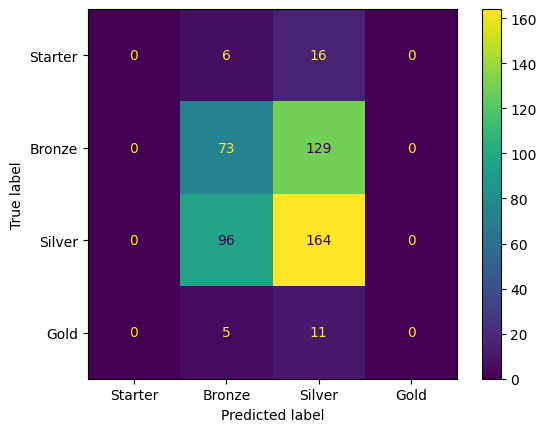

In [30]:
# exibir matriz de confusão  - mostra a acurácia da predições realizadas
confusion_matrix_model = confusion_matrix(y, y_pred, labels=lista_segmentos)
disp = ConfusionMatrixDisplay(
    confusion_matrix_model, display_labels=lista_segmentos)
disp.plot()

Conclusões:

- segmentos Starter e Gold com acurácia praticamente nula
- empresas estão sendo mal-classificadas (empresas prevista como Gold sendo classficada por Bronze)



#### Tuning de Hiperparâmetros

Nesta aula, discutimos a importância de ajustar os hiperparâmetros de um modelo de machine learning para melhorar sua performance. Exploramos a biblioteca Optuna, que automatiza o processo de busca pelos melhores hiperparâmetros. Focamos em dois hiperparâmetros específicos: MinSamplesLeaf e MaxDepth. Discutimos como esses hiperparâmetros afetam o desempenho do modelo e como definir um espaço de busca adequado para eles. Demonstramos como usar o Optuna para executar experimentos e encontrar os melhores hiperparâmetros. Ao final, mostramos o melhor resultado obtido e os hiperparâmetros correspondentes. O objetivo dessa abordagem é maximizar a acurácia do modelo.



In [31]:
# ajustar hiperparâmetros do modelo usando 'optuna'
# min_simples_leaf = mínimo de instâncias requerido para formar uma folha (nó terminal)
# max_depth = profundidade máxima da árvore

def decisiontree_optuna(trial):

    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 2)
    max_depth = trial.suggest_int('max_depth', 2, 8)

    dt_model.set_params(classifier__min_samples_leaf=min_samples_leaf)
    dt_model.set_params(classifier__max_depth=max_depth)

    scores = cross_val_score(dt_model, X, y, cv=cv_folds, scoring='accuracy')

    return scores.mean()

In [32]:
# executar a automação de experimentos
estudy_decisiontree = optuna.create_study(direction='maximize')
estudy_decisiontree.optimize(decisiontree_optuna, n_trials=200)

[I 2024-04-18 14:40:27,234] A new study created in memory with name: no-name-c88218ef-a2c8-48a2-b4a9-1da76fa3500d
[I 2024-04-18 14:40:27,279] Trial 0 finished with value: 0.45398359906692637 and parameters: {'min_samples_leaf': 2, 'max_depth': 5}. Best is trial 0 with value: 0.45398359906692637.
[I 2024-04-18 14:40:27,320] Trial 1 finished with value: 0.45398359906692637 and parameters: {'min_samples_leaf': 2, 'max_depth': 5}. Best is trial 0 with value: 0.45398359906692637.
[I 2024-04-18 14:40:27,368] Trial 2 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 1, 'max_depth': 7}. Best is trial 2 with value: 0.4739917754851743.
[I 2024-04-18 14:40:27,407] Trial 3 finished with value: 0.4739917754851743 and parameters: {'min_samples_leaf': 1, 'max_depth': 6}. Best is trial 2 with value: 0.4739917754851743.
[I 2024-04-18 14:40:27,437] Trial 4 finished with value: 0.4699877353726283 and parameters: {'min_samples_leaf': 2, 'max_depth': 3}. Best is trial 2 with valu

In [33]:
# mostrar melhor resultado e melhor conjunto de hiperparêmetros
print(f'Melhor acurácia: {estudy_decisiontree.best_value}')
print(f'Melhores parâmetros: {estudy_decisiontree.best_params}')

Melhor acurácia: 0.4740518962075848
Melhores parâmetros: {'min_samples_leaf': 1, 'max_depth': 2}


#### Visualizar Árvore de Decisão

Neste vídeo, aprendemos como visualizar uma árvore de decisão gerada por um algoritmo. Para isso, fizemos algumas transformações nos dados para prepará-los para a visualização. Criamos uma cópia do conjunto de dados e realizamos uma codificação das variáveis categóricas para que pudéssemos representá-las na árvore. Em seguida, treinamos o modelo com os hiperparâmetros ideais e utilizamos o método Plot Tree para visualizar a árvore resultante. Interpretamos os valores presentes no gráfico, como as perguntas feitas pelo modelo e as classes atribuídas a cada ramo da árvore. Observamos que o modelo teve dificuldade em distinguir entre as classes Silver e Bronze. Concluímos ressaltando a importância da interpretabilidade dos modelos e encerramos o vídeo.



In [34]:
# preparar o conjunto de dados para treinar e exibir a árvore
X_train_tree = X.copy()
X_train_tree['localizacao_label'] = X_train_tree['localizacao'].astype(
    'category').cat.codes
X_train_tree['aticidade_economica_label'] = X_train_tree['atividade_economica'].astype(
    'category').cat.codes
X_train_tree.drop(
    columns=['localizacao', 'atividade_economica'], axis=1, inplace=True)
X_train_tree.rename(columns={'localizacao_label': 'localizacao',
                    'aticidade_economica_label': 'atividade_economica'}, inplace=True)
X_train_tree.head()

,faturamento_mensal,numero_de_funcionarios,idade,inovacao,localizacao,atividade_economica
0,713109.95,12,6,1,1,1
1,790714.38,9,15,0,2,1
2,1197239.33,17,4,9,2,1
3,449185.78,15,6,0,2,2
4,1006373.16,15,15,8,2,0


In [35]:
# treinar o modelo com o conjunto de hiperparêmetros ideal

clf_desiciontree = DecisionTreeClassifier(
    min_samples_leaf=estudy_decisiontree.best_params['min_samples_leaf'], max_depth=estudy_decisiontree.best_params['max_depth'])

y_train_tree = y.copy()

clf_desiciontree.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(max_depth=2)

[Text(0.5, 0.8333333333333334, 'inovacao <= 2.5\ngini = 0.563\nsamples = 500\nvalue = [202, 16, 260, 22]\nclass = Silver'),
 Text(0.25, 0.5, 'faturamento_mensal <= 425959.422\ngini = 0.482\nsamples = 165\nvalue = [112, 0, 35, 18]\nclass = Starter'),
 Text(0.125, 0.16666666666666666, 'gini = 0.26\nsamples = 13\nvalue = [2, 0, 0, 11]\nclass = Gold'),
 Text(0.375, 0.16666666666666666, 'gini = 0.421\nsamples = 152\nvalue = [110, 0, 35, 7]\nclass = Starter'),
 Text(0.75, 0.5, 'faturamento_mensal <= 549601.438\ngini = 0.474\nsamples = 335\nvalue = [90.0, 16.0, 225.0, 4.0]\nclass = Silver'),
 Text(0.625, 0.16666666666666666, 'gini = 0.459\nsamples = 37\nvalue = [26, 0, 7, 4]\nclass = Starter'),
 Text(0.875, 0.16666666666666666, 'gini = 0.416\nsamples = 298\nvalue = [64.0, 16.0, 218.0, 0.0]\nclass = Silver')]

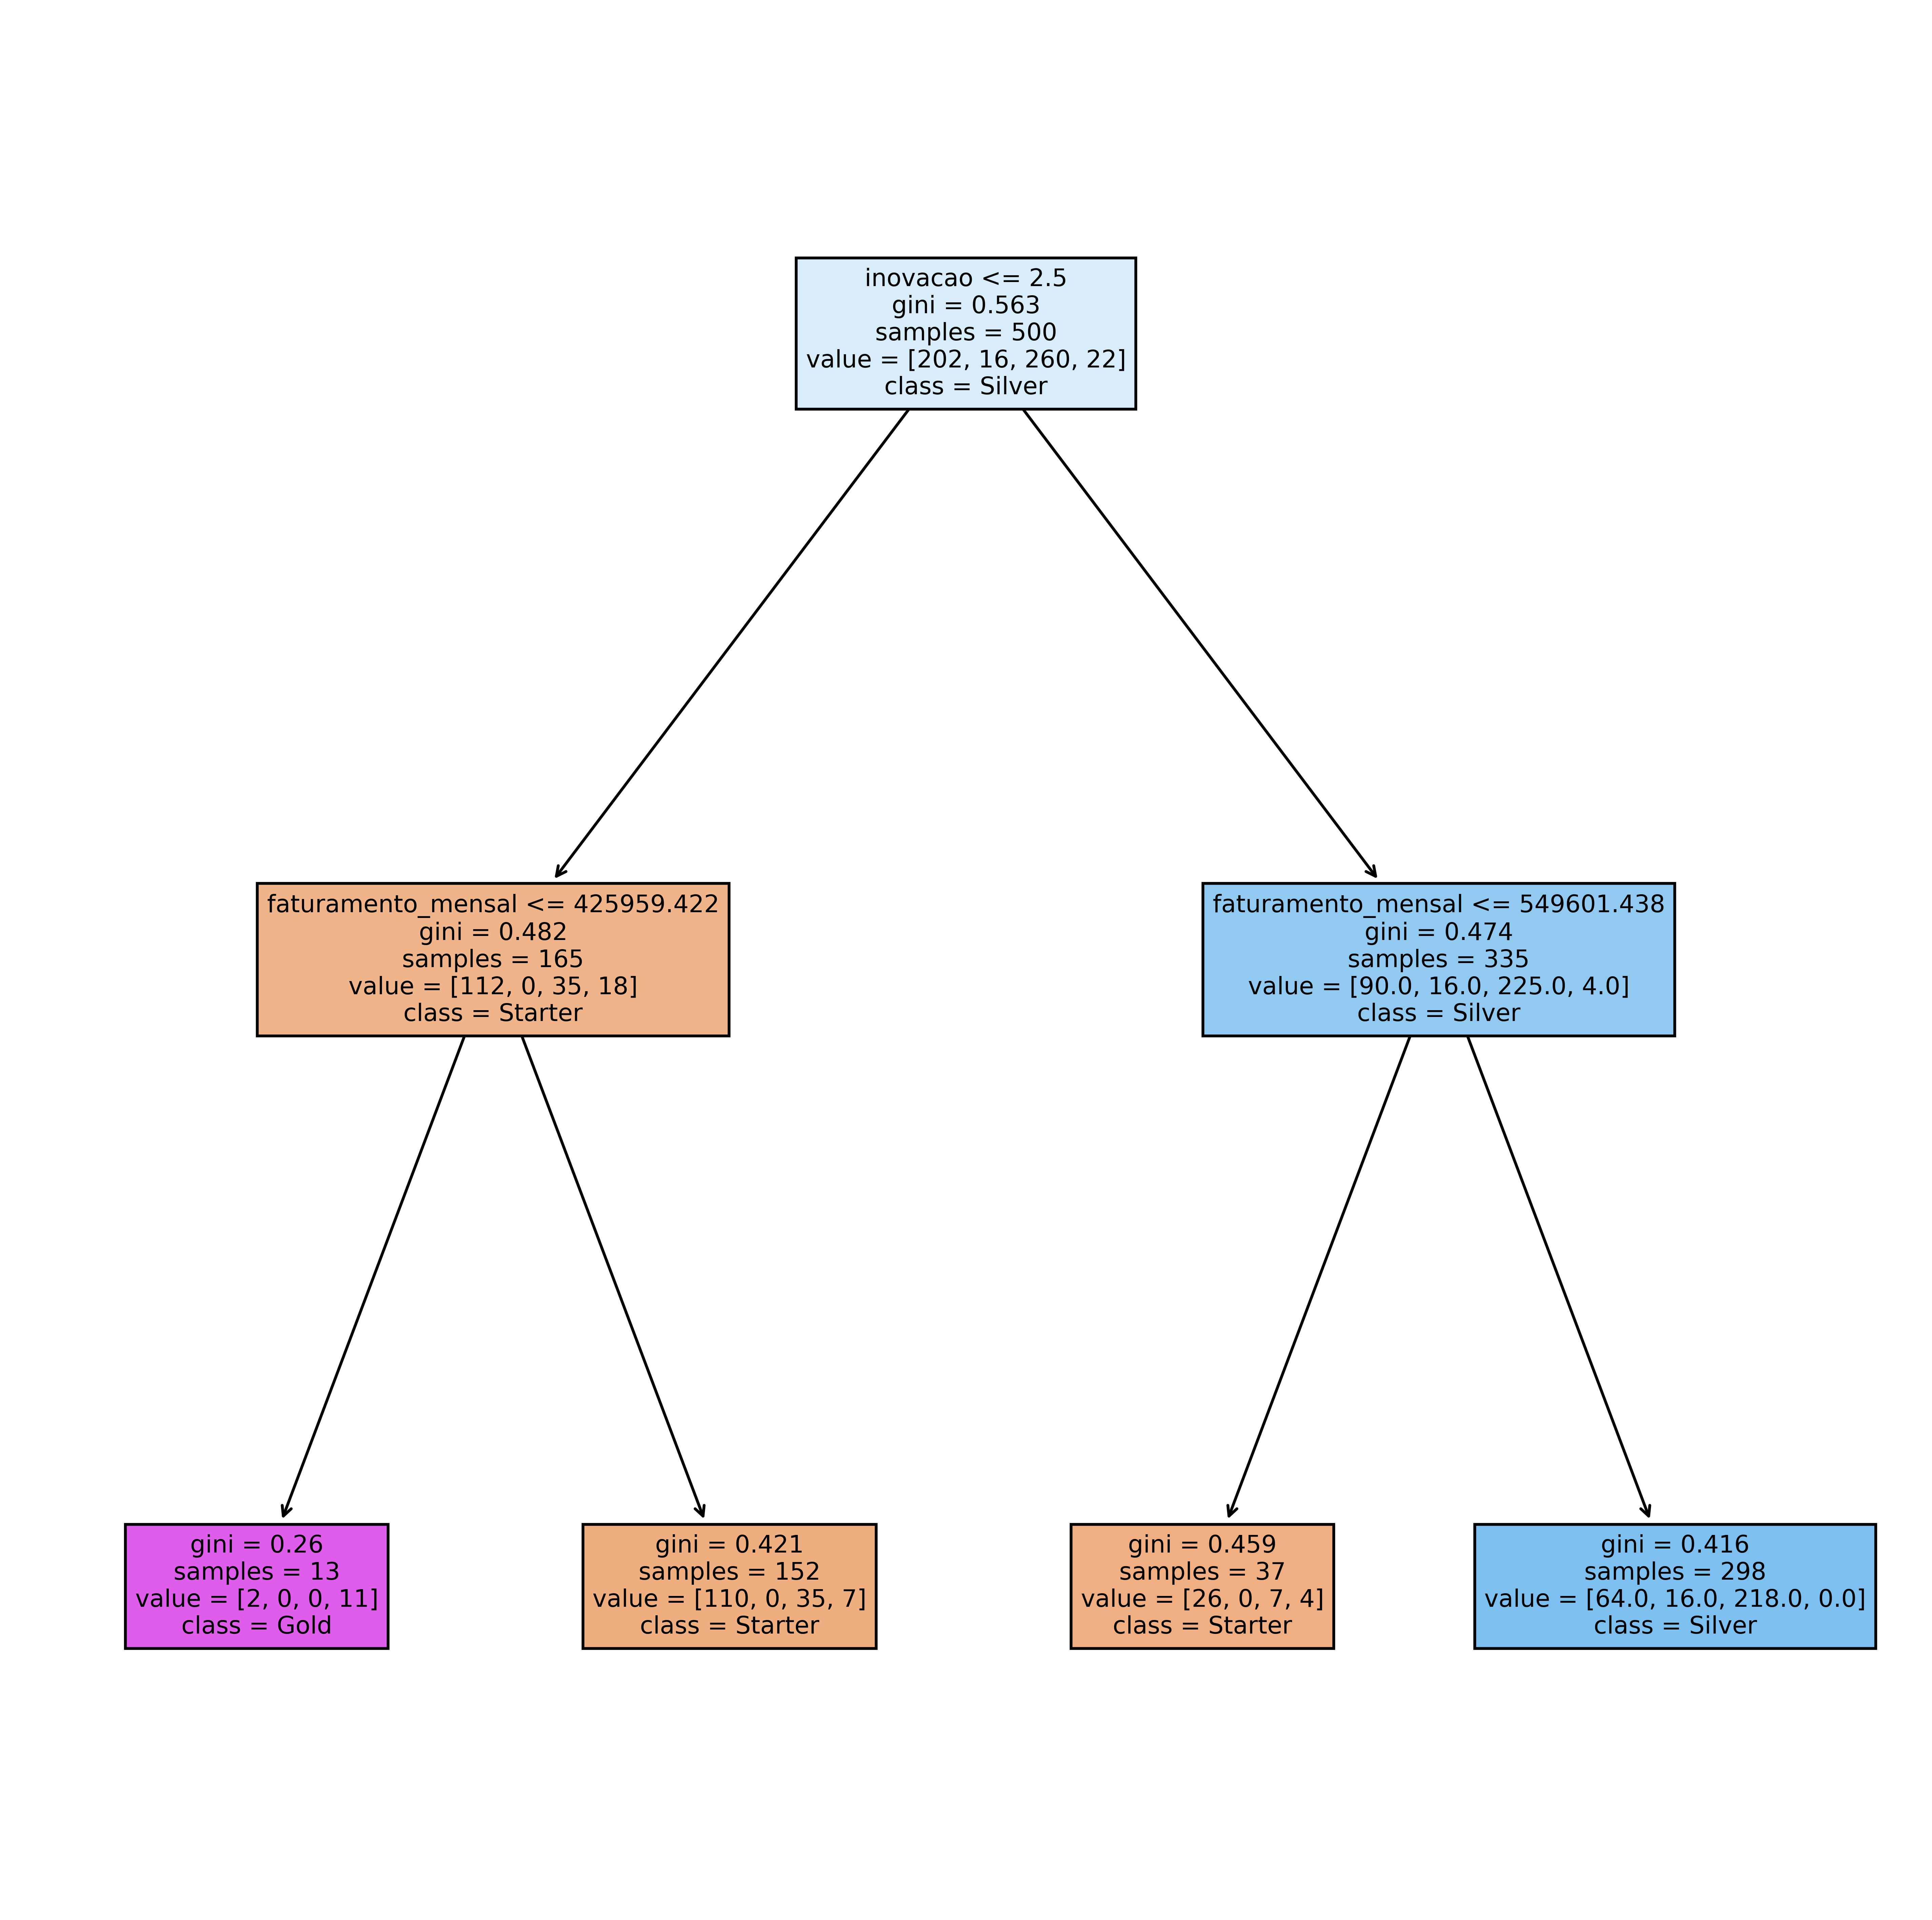

In [36]:
# visualizar árvore de decisão
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=600)

# Convertendo o ndarray em uma lista de strings
feature_names_list = list(X_train_tree.columns)

# Agora você pode passar 'feature_names_list' para a função plot_tree
plot_tree(clf_desiciontree, feature_names=feature_names_list,
          class_names=lista_segmentos, filled=True)

### Bloco 3 - Construir Aplicação Batch

#### Salvar Modelo

Nesta aula, aprendemos como salvar um modelo de machine learning para uso posterior. Utilizamos a biblioteca JobLib para criar um pipeline com o modelo tunado, ou seja, com os melhores hiperparâmetros. O pipeline consiste em dois steps: o preprocessor, que realiza as transformações das colunas, e o classifier, que é o classificador em si. Após treinar o modelo, utilizamos a função joblib.dump() para salvar o modelo em um arquivo. Com isso, podemos utilizar esse modelo para fazer predições em batch.


In [37]:
# criar um pipeline 'tunado'
dt_model_tunado = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(
    min_samples_leaf=estudy_decisiontree.best_params['min_samples_leaf'], max_depth=estudy_decisiontree.best_params['max_depth']))])

# treinar modelo tunado
dt_model_tunado.fit(X,y)

# salvar modelo
joblib.dump(dt_model_tunado,'../data/model_classification_decision_tree.plk')

['../data/model_classification_decision_tree.plk']

#### Entregar Aplicação Batch

Nesta aula, criamos um DataFrame chamado "Empresas" e definimos a função "predict". Essa função recebe um arquivo como entrada e lê esse arquivo para um DataFrame. Em seguida, fazemos a predição usando o modelo carregado anteriormente e criamos um novo DataFrame chamado "Segmentos" com a classificação resultante. Depois, concatenamos os DataFrames de entrada e saída em um novo DataFrame chamado "Predições" e salvamos esse DataFrame como um arquivo CSV. Por fim, usamos o gradio para criar uma interface visual simples que permite ao usuário fazer o upload de um arquivo, executar a função de predição e fazer o download do arquivo resultante. Essa abordagem é útil para lidar com predições em lote, onde recebemos um arquivo com informações e retornamos um arquivo com as informações e a classificação feita pelo modelo.

In [41]:
model = joblib.load('../data/model_classification_decision_tree.plk')

def predict(file):
    df_empresas = pd.read_csv(file.name)
    y_pred = model.predict(df_empresas)
    df_segmentos = pd.DataFrame(y_pred, columns=['segmento_de_cliente'])
    df_predicoes = pd.concat([df_empresas, df_segmentos], axis=1)
    df_predicoes.to_csv('../datasets/segmentos_predicoes.csv', index=False)
    return '../datasets/segmentos_predicoes.csv'

demo = gr.Interface(predict, gr.File(file_types=[".csv"]), "file")

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [40]:
def stop_gradio():
    demo.close()
    print("Servidor Gradio foi interrompido.")

stop_gradio()

Closing server running on port: 7860
Servidor Gradio foi interrompido.
